# **Flight Prediction Model**
In this model

In [ ]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
# Load the training and test datasets
train_path = 'Data_Train.csv'
test_path = 'Test_set.csv'
data_train = pd.read_csv(train_path)
test_set = pd.read_csv(test_path)


In [ ]:
# Preprocess data: Extract meaningful features from dates and times
data_train['Date_of_Journey'] = pd.to_datetime(data_train['Date_of_Journey'], format='%d/%m/%Y')
test_set['Date_of_Journey'] = pd.to_datetime(test_set['Date_of_Journey'], format='%d/%m/%Y')

data_train['Journey_Day'] = data_train['Date_of_Journey'].dt.day
data_train['Journey_Month'] = data_train['Date_of_Journey'].dt.month
test_set['Journey_Day'] = test_set['Date_of_Journey'].dt.day
test_set['Journey_Month'] = test_set['Date_of_Journey'].dt.month

data_train['Dep_Time'] = pd.to_datetime(data_train['Dep_Time'])
test_set['Dep_Time'] = pd.to_datetime(test_set['Dep_Time'])
data_train['Arrival_Time'] = pd.to_datetime(data_train['Arrival_Time'])
test_set['Arrival_Time'] = pd.to_datetime(test_set['Arrival_Time'])

data_train['Dep_Hour'] = data_train['Dep_Time'].dt.hour
data_train['Dep_Minute'] = data_train['Dep_Time'].dt.minute
data_train['Arrival_Hour'] = data_train['Arrival_Time'].dt.hour
data_train['Arrival_Minute'] = data_train['Arrival_Time'].dt.minute

test_set['Dep_Hour'] = test_set['Dep_Time'].dt.hour
test_set['Dep_Minute'] = test_set['Dep_Time'].dt.minute
test_set['Arrival_Hour'] = test_set['Arrival_Time'].dt.hour
test_set['Arrival_Minute'] = test_set['Arrival_Time'].dt.minute

<ipython-input-13-8c460fedd2e7>:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data_train['Dep_Time'] = pd.to_datetime(data_train['Dep_Time'])
<ipython-input-13-8c460fedd2e7>:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  test_set['Dep_Time'] = pd.to_datetime(test_set['Dep_Time'])
<ipython-input-13-8c460fedd2e7>:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data_train['Arrival_Time'] = pd.to_datetime(data_train['Arrival_Time'])
<ipython-input-13-8c460fedd2e7>:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dat

In [ ]:
def convert_duration_to_minutes(duration):
    duration = duration.split()
    hours = int(duration[0][:-1]) if 'h' in duration[0] else 0
    minutes = int(duration[1][:-1]) if len(duration) > 1 and 'm' in duration[1] else 0
    return hours * 60 + minutes

data_train['Duration_Minutes'] = data_train['Duration'].apply(convert_duration_to_minutes)
test_set['Duration_Minutes'] = test_set['Duration'].apply(convert_duration_to_minutes)

data_train['Total_Stops'] = data_train['Total_Stops'].fillna('non-stop')
stop_mapping = {'non-stop': 0, '1 stop': 1, '2 stops': 2, '3 stops': 3, '4 stops': 4}
data_train['Total_Stops'] = data_train['Total_Stops'].map(stop_mapping)
test_set['Total_Stops'] = test_set['Total_Stops'].map(stop_mapping)

In [ ]:
# Drop unnecessary columns
columns_to_drop = ['Date_of_Journey', 'Dep_Time', 'Arrival_Time', 'Route', 'Duration', 'Additional_Info']
data_train = data_train.drop(columns=columns_to_drop)
test_set_preprocessed = test_set.drop(columns=columns_to_drop)  # Keep original test_set untouched


In [ ]:
# Encode categorical variables for model training, but retain original columns for visualization
encoder = LabelEncoder()
data_train['Airline_Encoded'] = encoder.fit_transform(data_train['Airline'])
test_set_preprocessed['Airline_Encoded'] = encoder.transform(test_set['Airline'])

data_train['Source_Encoded'] = encoder.fit_transform(data_train['Source'])
test_set_preprocessed['Source_Encoded'] = encoder.transform(test_set['Source'])

data_train['Destination_Encoded'] = encoder.fit_transform(data_train['Destination'])
test_set_preprocessed['Destination_Encoded'] = encoder.transform(test_set['Destination'])


In [ ]:
# Prepare features and target
X = data_train[['Airline_Encoded', 'Source_Encoded', 'Destination_Encoded', 'Total_Stops',
                'Journey_Day', 'Journey_Month', 'Dep_Hour', 'Dep_Minute', 'Arrival_Hour',
                'Arrival_Minute', 'Duration_Minutes']]
y = data_train['Price']

In [ ]:
# Split the data for training and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(test_set_preprocessed[['Airline_Encoded', 'Source_Encoded',
                                                         'Destination_Encoded', 'Total_Stops',
                                                         'Journey_Day', 'Journey_Month', 'Dep_Hour',
                                                         'Dep_Minute', 'Arrival_Hour', 'Arrival_Minute',
                                                         'Duration_Minutes']])



In [ ]:
# Hyperparameter tuning for KNN
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}
grid_search = GridSearchCV(KNeighborsRegressor(), param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)
grid_search.fit(X_train_scaled, y_train)

best_knn_model = grid_search.best_estimator_


Fitting 5 folds for each of 16 candidates, totalling 80 fits


In [ ]:
# Evaluate the tuned KNN model
y_val_pred = best_knn_model.predict(X_val_scaled)
rmse = mean_squared_error(y_val, y_val_pred, squared=False)
r2 = r2_score(y_val, y_val_pred)
print(f"Tuned KNN Model RMSE: {rmse:.2f}, R² Score: {r2:.2f}")

Tuned KNN Model RMSE: 2270.48, R² Score: 0.76


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## Residual Plot:
  
  * The residual plot shows the difference between actual and predicted values **(Residuals = Actual - Predicted)** against the actual values.
  * Random Distribution:
    * If the residuals are randomly scattered around 0, the model fits the data well. **In our case, residuals seem mostly random, indicating a good fit.**
  * Outliers:
    * Any points far from 0 indicate predictions with high error. **Outliers indicate areas where the model struggles**, such as rare routes or unusual prices.
  * Patterns:
    * If residuals form a curve or pattern, it suggests non-linearity or systematic errors in the prediction. In our plot, **there’s no distinct pattern**, indicating the model is not systematically biased.


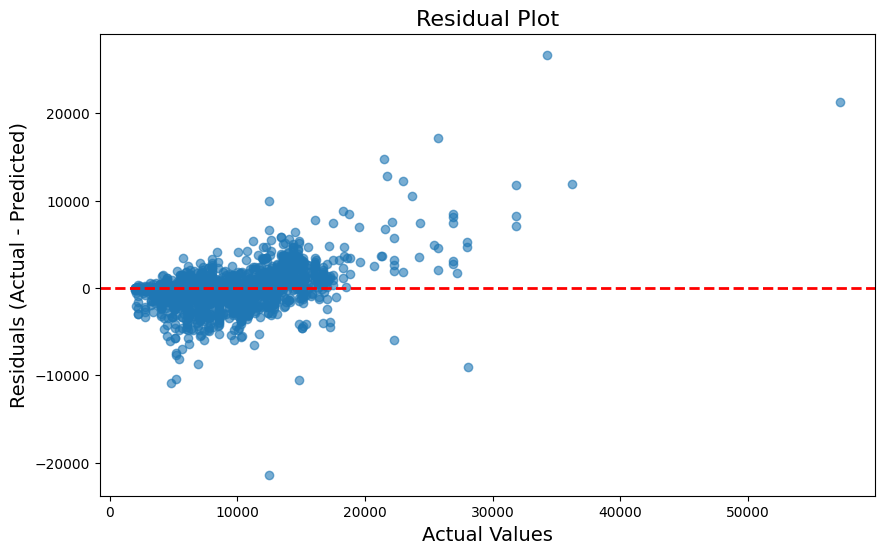

In [ ]:
import matplotlib.pyplot as plt

# Calculate residuals
residuals = y_val - y_val_pred

# Residual plot
plt.figure(figsize=(10, 6))
plt.scatter(y_val, residuals, alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.title('Residual Plot', fontsize=16)
plt.xlabel('Actual Values', fontsize=14)
plt.ylabel('Residuals (Actual - Predicted)', fontsize=14)
plt.savefig('residual_plot.png')
plt.show()

## Actual vs Predicted Plot:

  * This plot compares actual values against predicted values. Points close to the linear function(y=x) indicate accurate predictions.
  * Points Near the Line:
    * Most points align well with the linear function, indicating the **model's predictions are accurate for the majority** of the data.
  * Deviations:
    * Larger deviations from the line represent areas where the model has struggled. **High-priced flights show greater prediction errors**, as these are harder to predict due to unforseen parameters.
  * Overall Fit:
    * The plot confirms that the model is effective for the majority of flights, with **most predictions are close to actual values**.

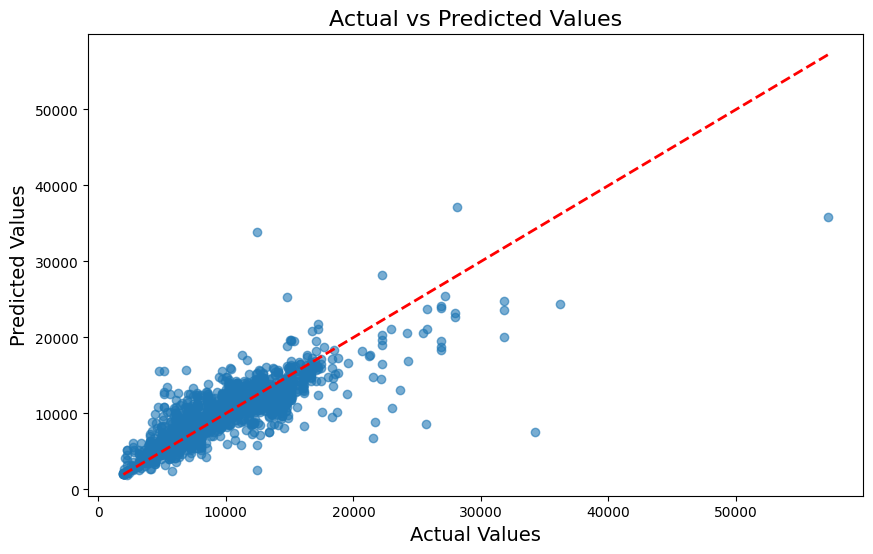

In [ ]:
# Actual vs. Predicted Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_val_pred, alpha=0.6)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], color='red', linestyle='--', linewidth=2)
plt.title('Actual vs Predicted Values', fontsize=16)
plt.xlabel('Actual Values', fontsize=14)
plt.ylabel('Predicted Values', fontsize=14)
plt.savefig('actual_vs_predicted')
plt.show()


In [ ]:
# Predict on the test set
test_set['Predicted_Price'] = best_knn_model.predict(X_test_scaled)

In [ ]:
# Save the test set with predictions
test_set.to_csv('Test_set_with_predictions.csv', index=False)

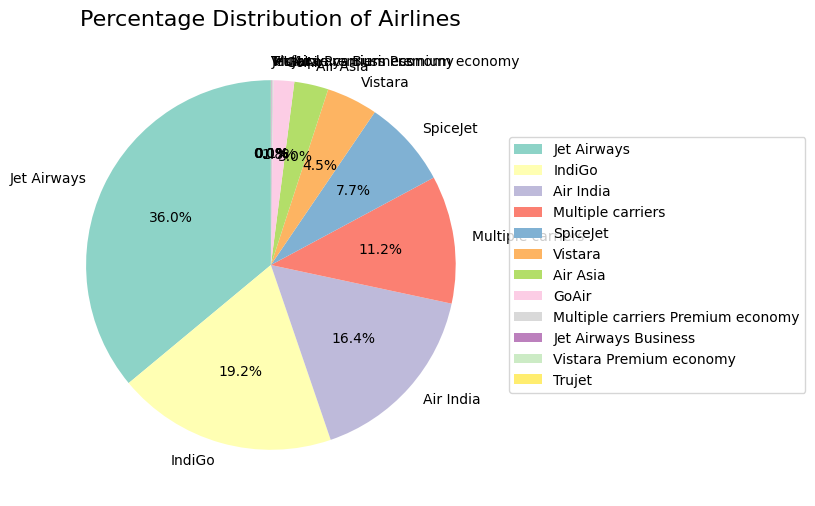

In [ ]:
# Calculate the count of each airline
airline_counts = data_train['Airline'].value_counts()

# Simplified and Clean Percentage Distribution of Airlines
plt.figure(figsize=(10, 6))

# Create the pie chart with better spacing
airline_counts.plot.pie(
    autopct='%1.1f%%',
    startangle=90,
    cmap='Set3',
    labeldistance=1.1  # Adjust the distance of labels from the center
)

# Add a legend beside the chart
plt.legend(airline_counts.index, loc="center left", bbox_to_anchor=(1, 0.5))

# Set the title
plt.title('Percentage Distribution of Airlines', fontsize=16)

# Remove the y-axis label for a cleaner presentation
plt.ylabel('')

# Saving the plot
plt.savefig('airline_distribution.png')

# Display the chart
plt.show()



## Price Distribution by Stops (Boxplot):

  * This boxplot shows how flight prices vary based on the number of stops. It **highlights trends and variability for different stop categories**.

  * Non-stop Flights:
      * **Non-stop flights generally have a smaller range of prices**, indicating consistency.
      * Median prices are lower compared to flights with stops.
  * More Stops = Higher Variability:
      * **Flights with 1 or more stops show higher variability**, with outliers significantly increasing prices.
      * Indicates that flights with stops might include premium long-haul routes or other factors influencing prices.
  * Operational Costs:
      * **Flights with more stops likely incur higher operational costs **(e.g., layover fees, additional routes), justifying higher prices.





<ipython-input-27-70c9446ec0f6>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data_train, x='Total_Stops', y='Price', palette='coolwarm')


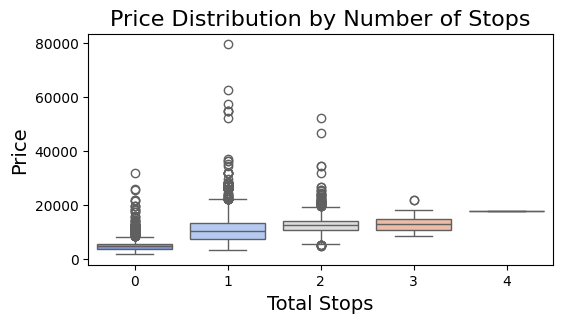

In [ ]:
# Visualization: Price Distribution by Stops
plt.figure(figsize=(6, 3))
sns.boxplot(data=data_train, x='Total_Stops', y='Price', palette='coolwarm')
plt.title('Price Distribution by Number of Stops', fontsize=16)
plt.xlabel('Total Stops', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.savefig('price_by_stops.png')
plt.show()

## Correlation Matrix of the Features in the Dataset

* The correlation matrix highlights the relationships between numerical features in the dataset, expressed as values between -1 and 1:
  * 1: Perfect positive correlation as **one variable increases**, the **other varaible increases** proportionally.

  * 0: No correlation and the variables are **independent**.

  * -1: Perfect negative correlation as **one variable increases**, the **other varaible decreases** proportionally.

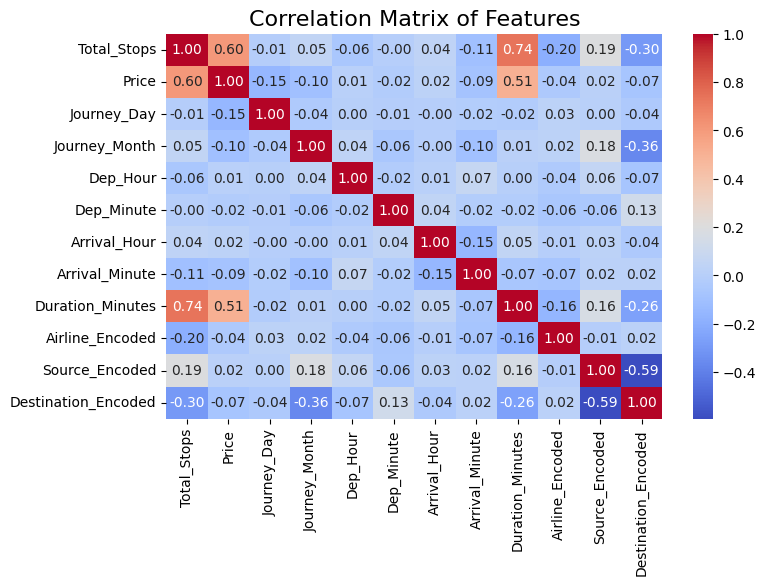

In [ ]:
# Select only numerical columns
numerical_features = data_train.select_dtypes(include=['number'])

# Compute correlation matrix
correlation_matrix = numerical_features.corr()

# Plot the heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Features', fontsize=16)
plt.savefig('correlation_matrix.png')
plt.show()